In [1]:
# TO DO

#1. lower leiden res
#2. new adata.obs column assigns 0 to left clusters and 1 to right
#   compare DGE between both
#3. new adata.obs column with genotypes 0 for WT and 1 for KO
#   compare DGE between both
#4. Volcano plot


In [2]:
import scanpy as sc
import anndata as ad
import pandas as pd
import gzip
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

adata = sc.read_h5ad("integrated_data.h5ad")

In [3]:
clustering = "leiden_res_0.35"

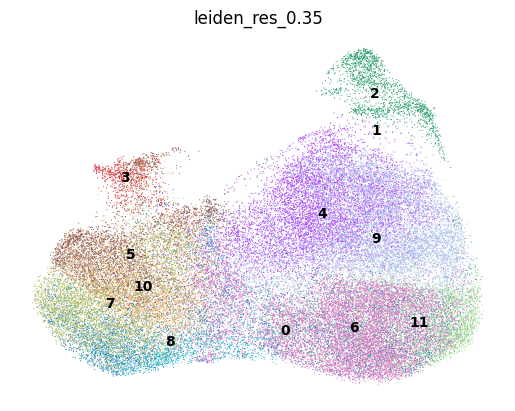

In [4]:
sc.pl.umap(
    adata,
    color=clustering,
    legend_loc="on data",
    frameon=False,
)

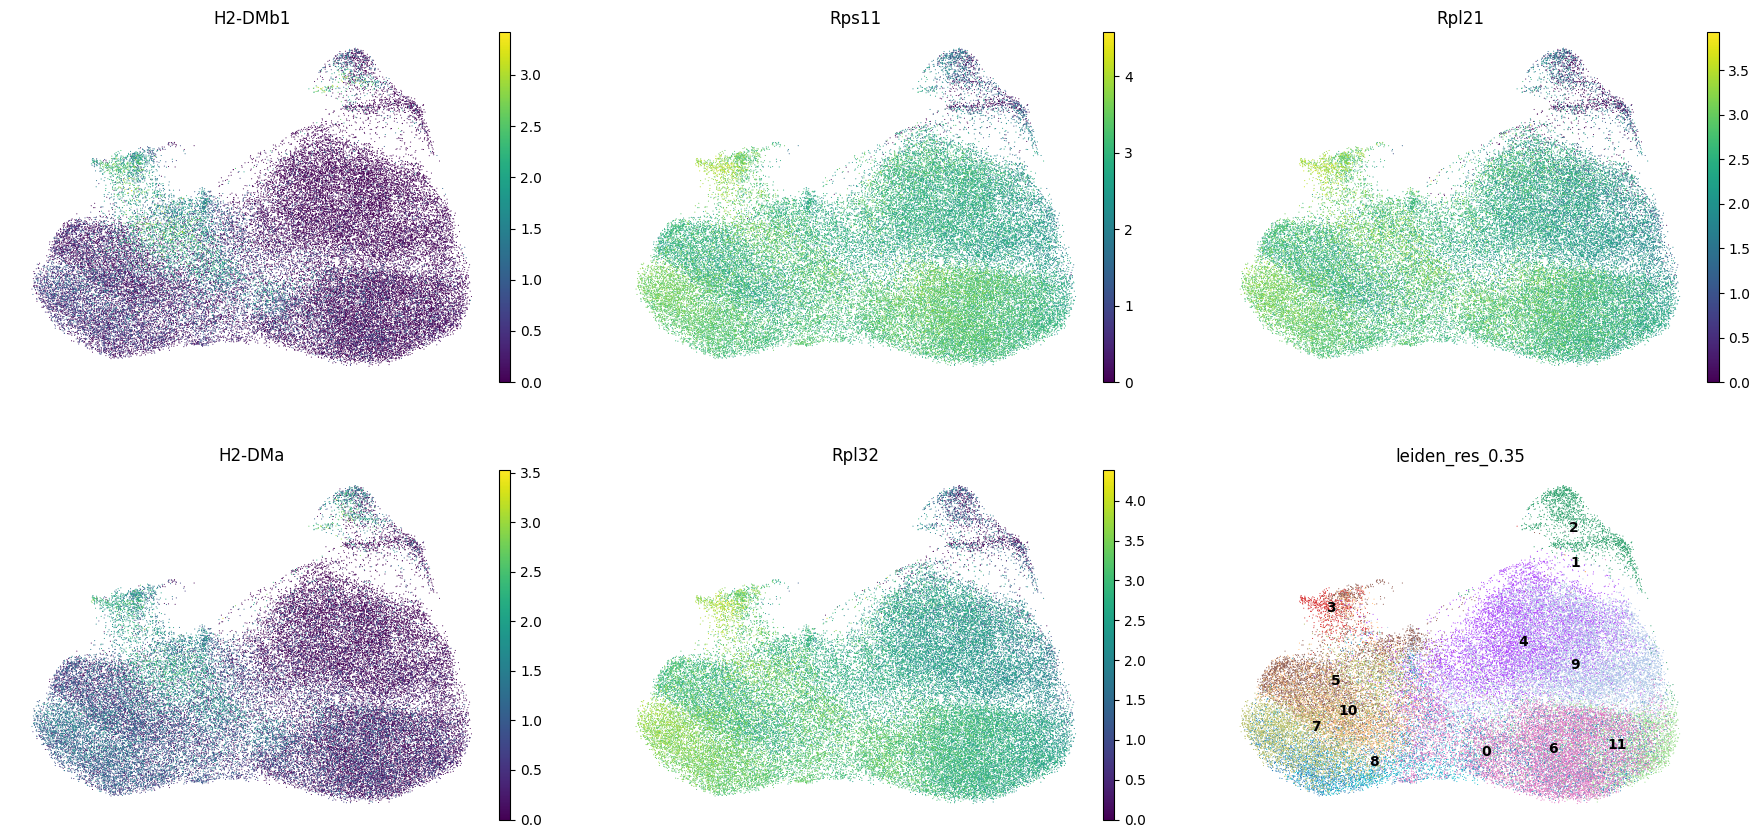

In [5]:
dc_cluster_genes = sc.get.rank_genes_groups_df(adata, group="5").head(5)["names"]
sc.pl.umap(
    adata,
    color=[*dc_cluster_genes, clustering],
    legend_loc="on data",
    frameon=False,
    ncols=3,
)

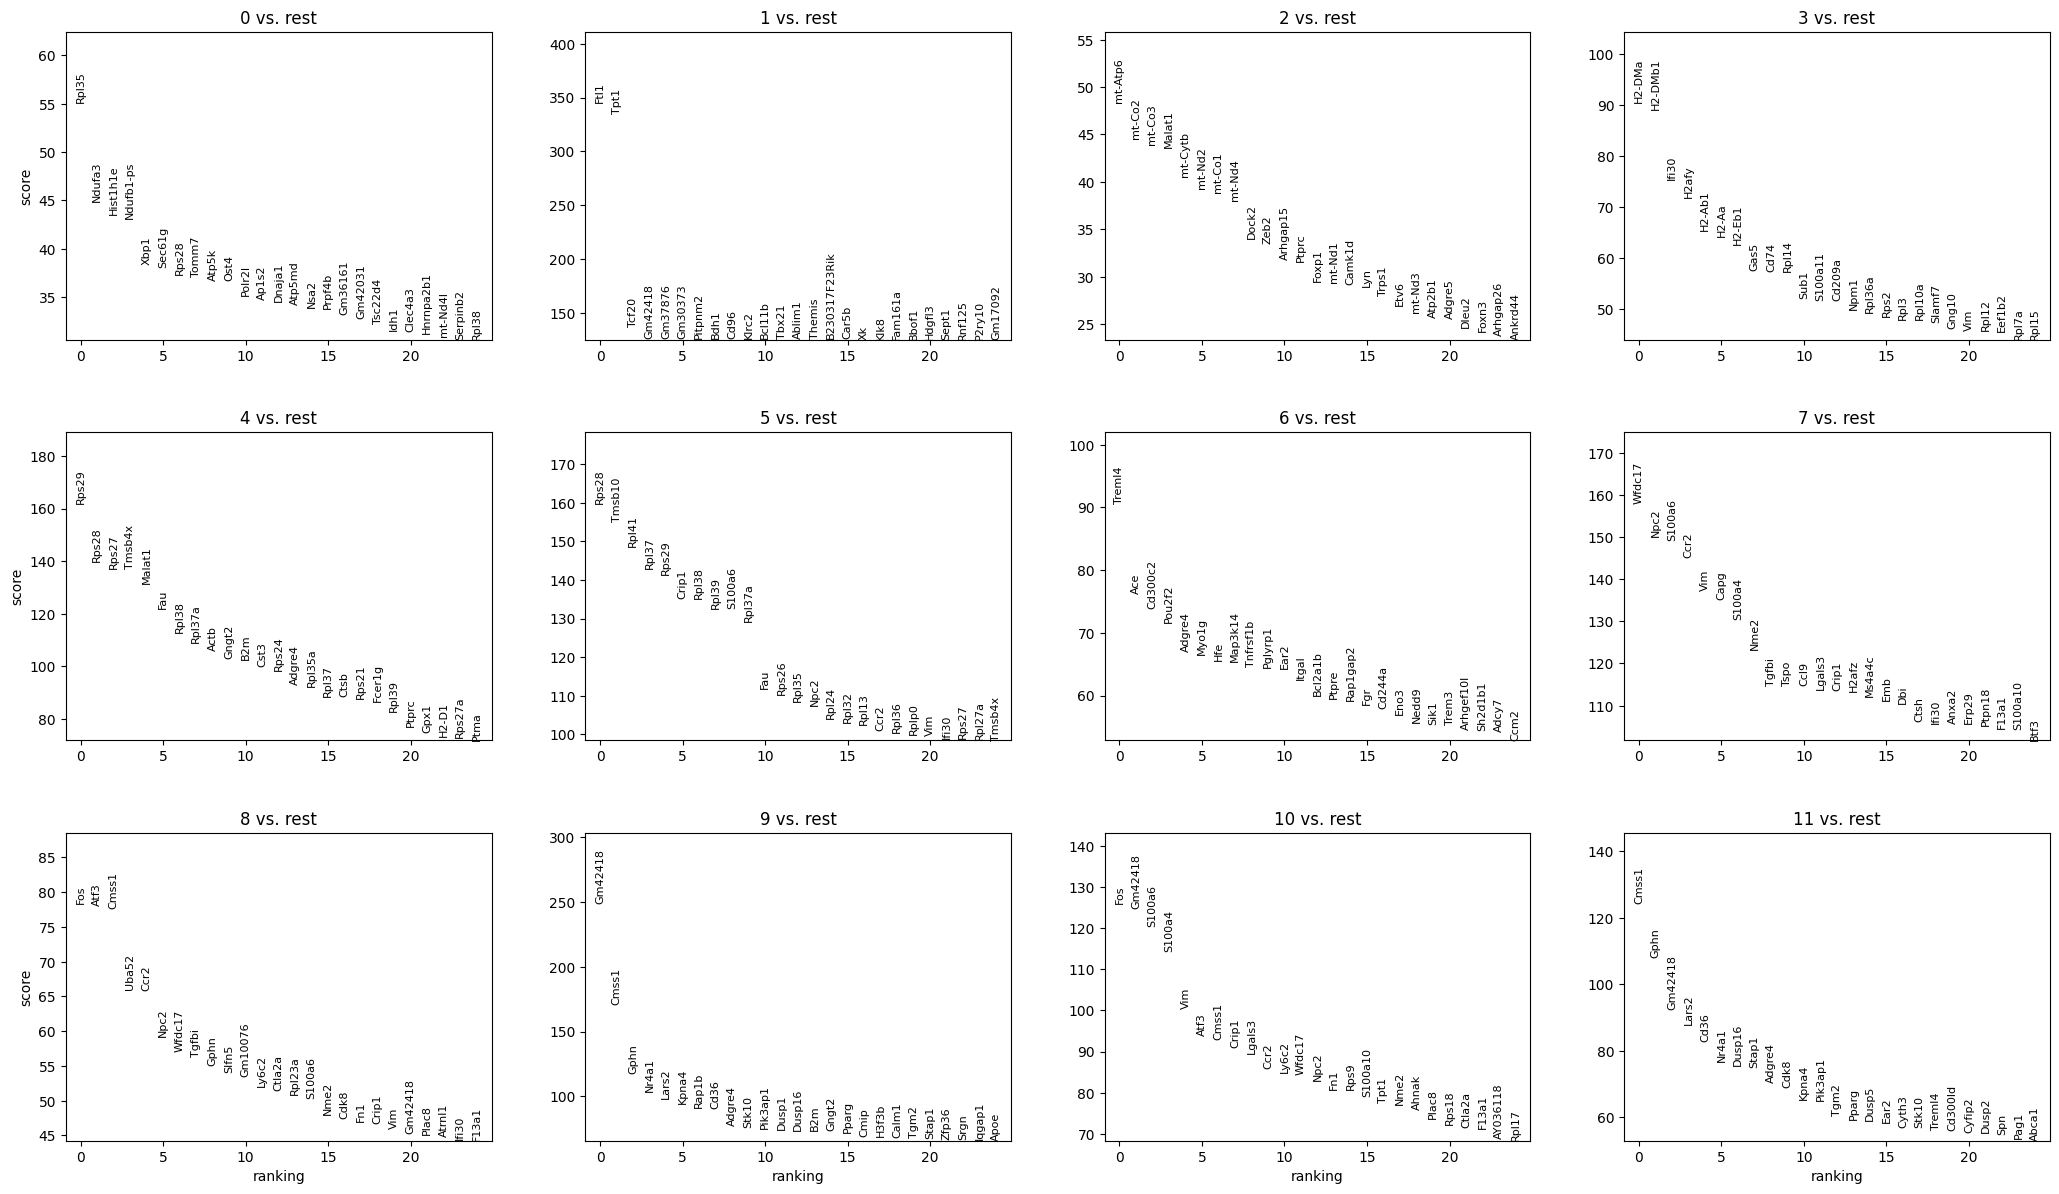

AnnData object with n_obs × n_vars = 51421 × 19307
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'mito_percentage', 'n_genes', 'doublet_score', 'predicted_doublet', 'leiden', 'source', 'leiden_res_0.02', 'leiden_res_0.35', 'leiden_res_0.50', 'leiden_res_2.00', 'cell_type_lvl1', 'umap_density_source'
    uns: 'dendrogram_leiden_res_0.50', 'leiden_res_0.02', 'leiden_res_0.02_colors', 'leiden_res_0.35', 'leiden_res_0.50', 'leiden_res_0.50_colors', 'leiden_res_2.00', 'leiden_res_2.00_colors', 'neighbors', 'pca', 'rank_genes_groups', 'source_colors', 'umap', 'umap_density_source_params', 'leiden_res_0.35_colors', 'log1p', 't-test'
    o

In [6]:
adata.layers["counts"] = adata.X.copy() #copies raw count matrix into a new layer "counts", so raw data is preserved

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

#adata = adata.raw.to_adata()
#sc.pl.umap(adata, color='louvain_0.6')

sc.tl.rank_genes_groups(adata, clustering, method='t-test', key_added = "t-test", use_raw=False)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "t-test", use_raw=False)

# results are stored in the adata.uns["t-test"] slot
adata

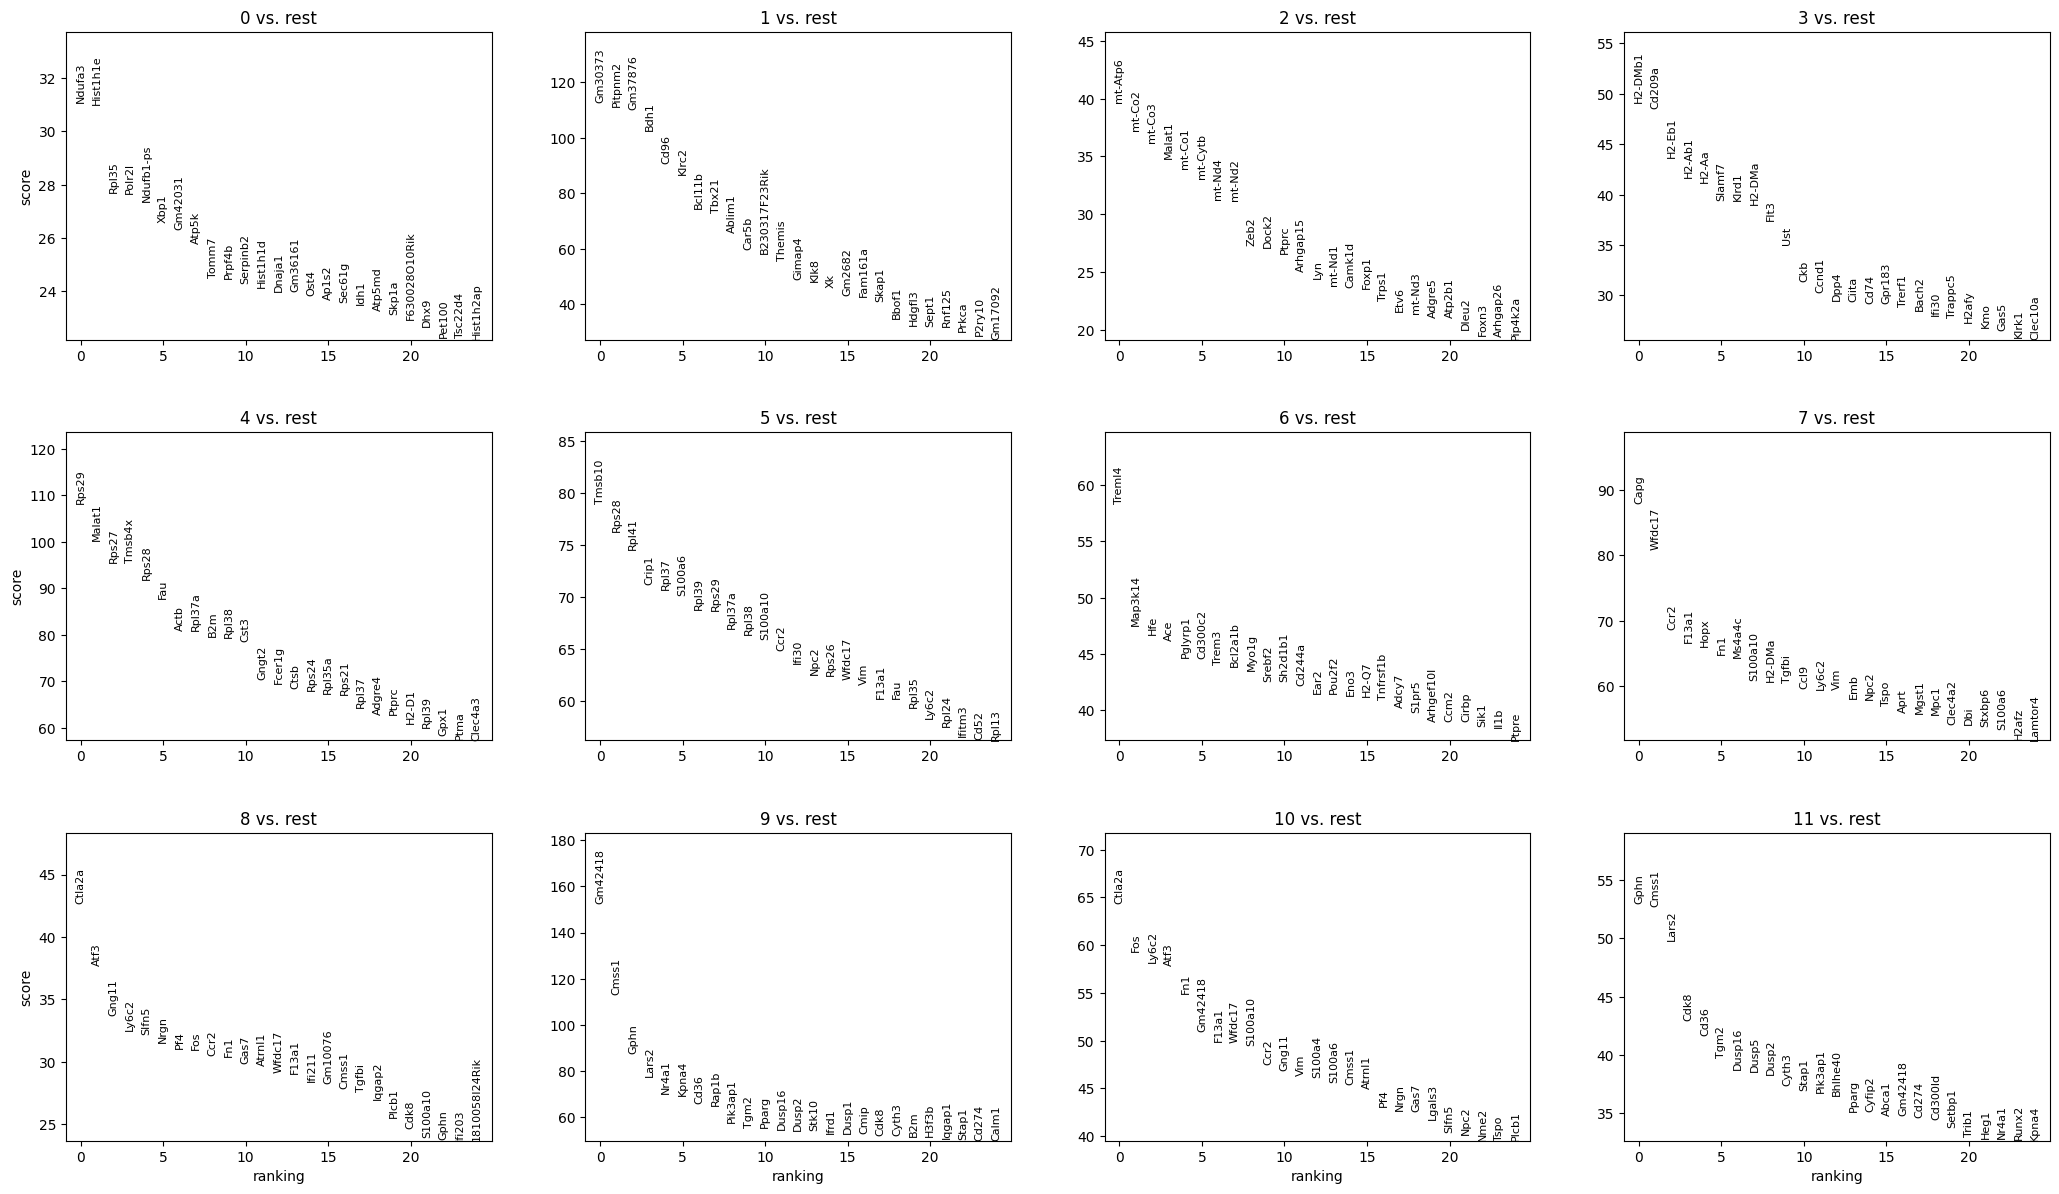

In [7]:
sc.tl.rank_genes_groups(adata, clustering, method='t-test_overestim_var', key_added = "t-test_ov")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "t-test_ov")

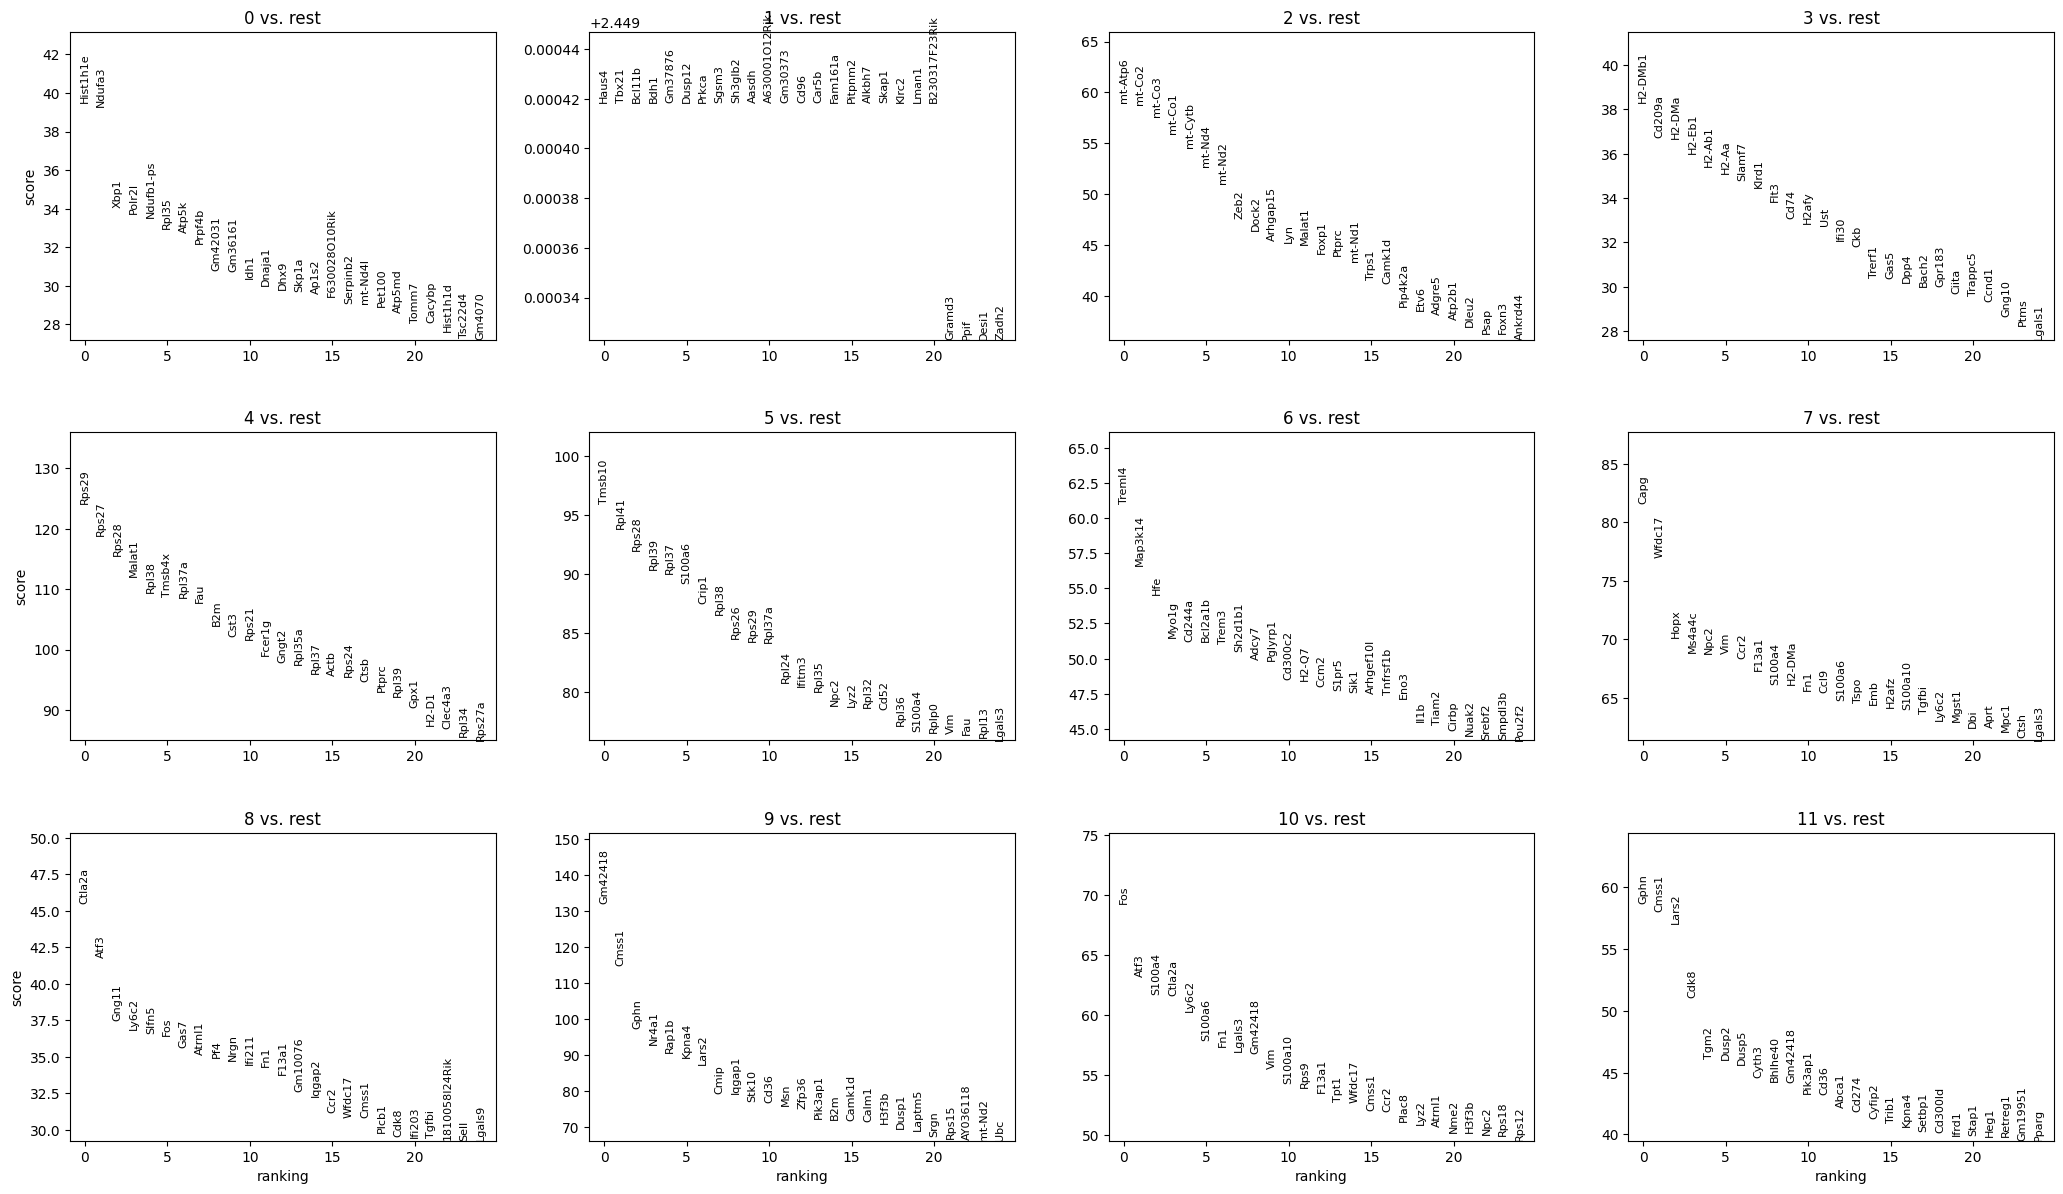

In [8]:
sc.tl.rank_genes_groups(adata, clustering, method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key="wilcoxon")

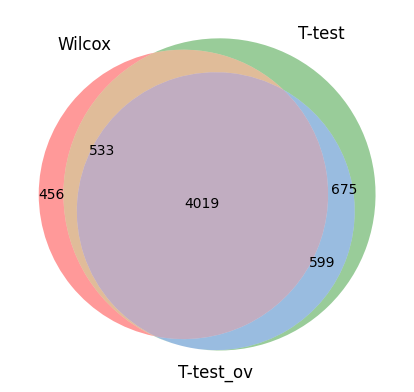

In [9]:
# WILCOX TEST
#compare cluster1 genes, only stores top 100 by default

wc = sc.get.rank_genes_groups_df(adata, group='0', key='wilcoxon', pval_cutoff=0.01, log2fc_min=0)['names']
tt = sc.get.rank_genes_groups_df(adata, group='0', key='t-test', pval_cutoff=0.01, log2fc_min=0)['names']
tt_ov = sc.get.rank_genes_groups_df(adata, group='0', key='t-test_ov', pval_cutoff=0.01, log2fc_min=0)['names']

from matplotlib_venn import venn3

venn3([set(wc),set(tt),set(tt_ov)], ('Wilcox','T-test','T-test_ov') )
plt.show()

monocytes: clusters [3, 4, 5, 6, 7, 8, 9, 10, 11]


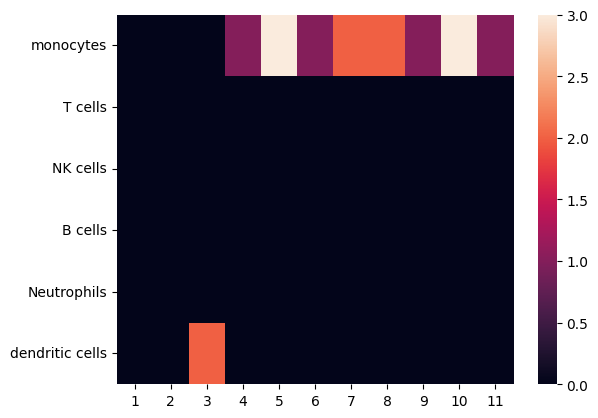

In [10]:
# Identifying clusters by cell type

cell_markers = {"monocytes": ["Itgam", "Plac8", #(should be high in all monocytes) 
    "Csf1r", "Ly6c2", "Cx3cr1", "Ace", "Spn", "Ccr2"], #(in biger subsets of monocytes)
    "T cells": ["Cd3e", "Cd3g", "Cd3e"], #(some can express Ly6c2)
    "NK cells": ["Nkg7", "Gzma"],
    "B cells": ["Cd79a", "Cd79b"],
    "Neutrophils": ["Ly6g", "Csf3r"], #(note: aslo express Itgam)
    "dendritic cells": ["Clec10a", "Clec9a", "Xcr1", "Flt3"], #(note: also express Itgam)
}
clusters = [1,2,3,4,5,6,7,8,9,10,11]

cluster_cell_types = {}
for cluster in clusters:
    marker_counts = {"monocytes": 0, "T cells": 0, "NK cells": 0, "B cells": 0, "Neutrophils": 0, "dendritic cells": 0}
    for cell in list(cell_markers.keys()):
        top_genes = list(sc.get.rank_genes_groups_df(adata, group=str(cluster), key='wilcoxon', pval_cutoff=0.01, log2fc_min=0)['names'][:100])
        for gene in top_genes:
            if gene in cell_markers[cell]:
                marker_counts[cell] += 1
    cluster_cell_types[cluster] = marker_counts

cct = pd.DataFrame(cluster_cell_types)
sns.heatmap(cct)

print(f"monocytes: clusters {list(cct.loc[:,cct.sum(axis=0) > 0].columns)}")

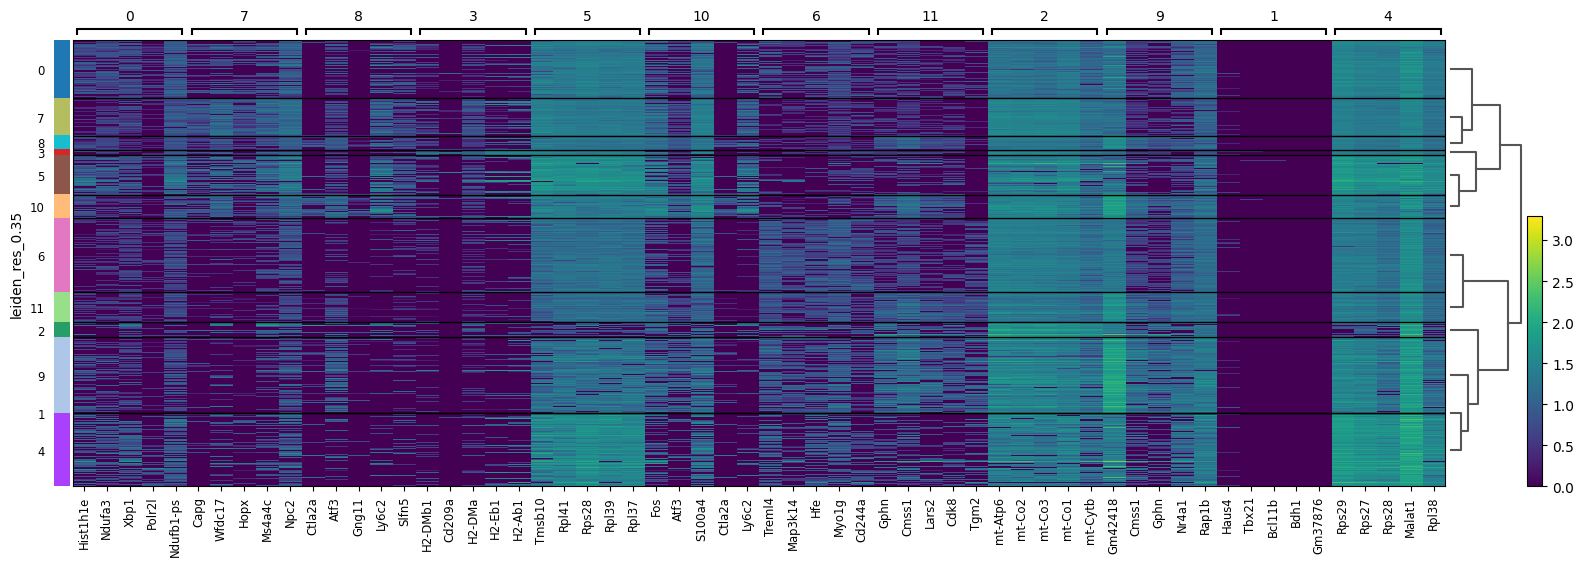

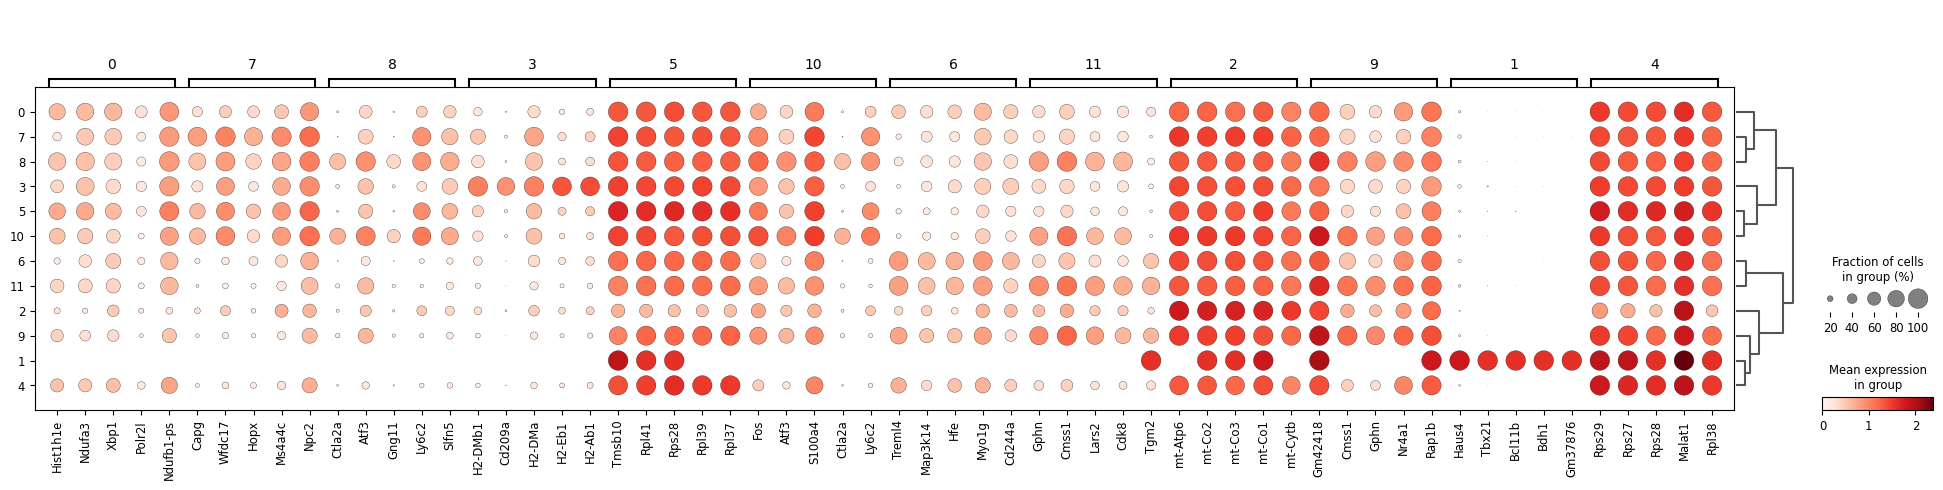

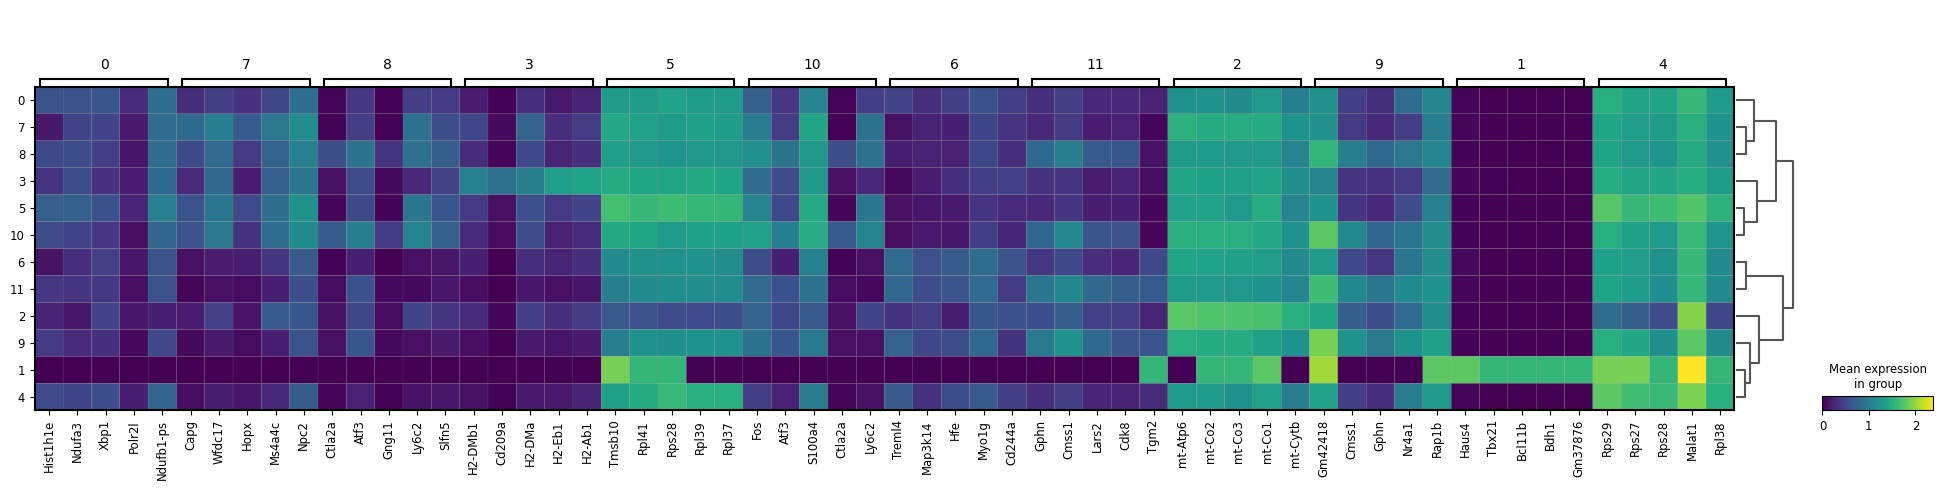

In [11]:
sc.tl.dendrogram(adata, groupby=clustering)
sc.pl.rank_genes_groups_heatmap(adata, n_genes=5, key="wilcoxon", groupby=clustering, show_gene_labels=True)
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, key="wilcoxon", groupby=clustering)
#sc.pl.rank_genes_groups_stacked_violin(adata, n_genes=5, key="wilcoxon", groupby=clustering)
sc.pl.rank_genes_groups_matrixplot(adata, n_genes=5, key="wilcoxon", groupby=clustering)

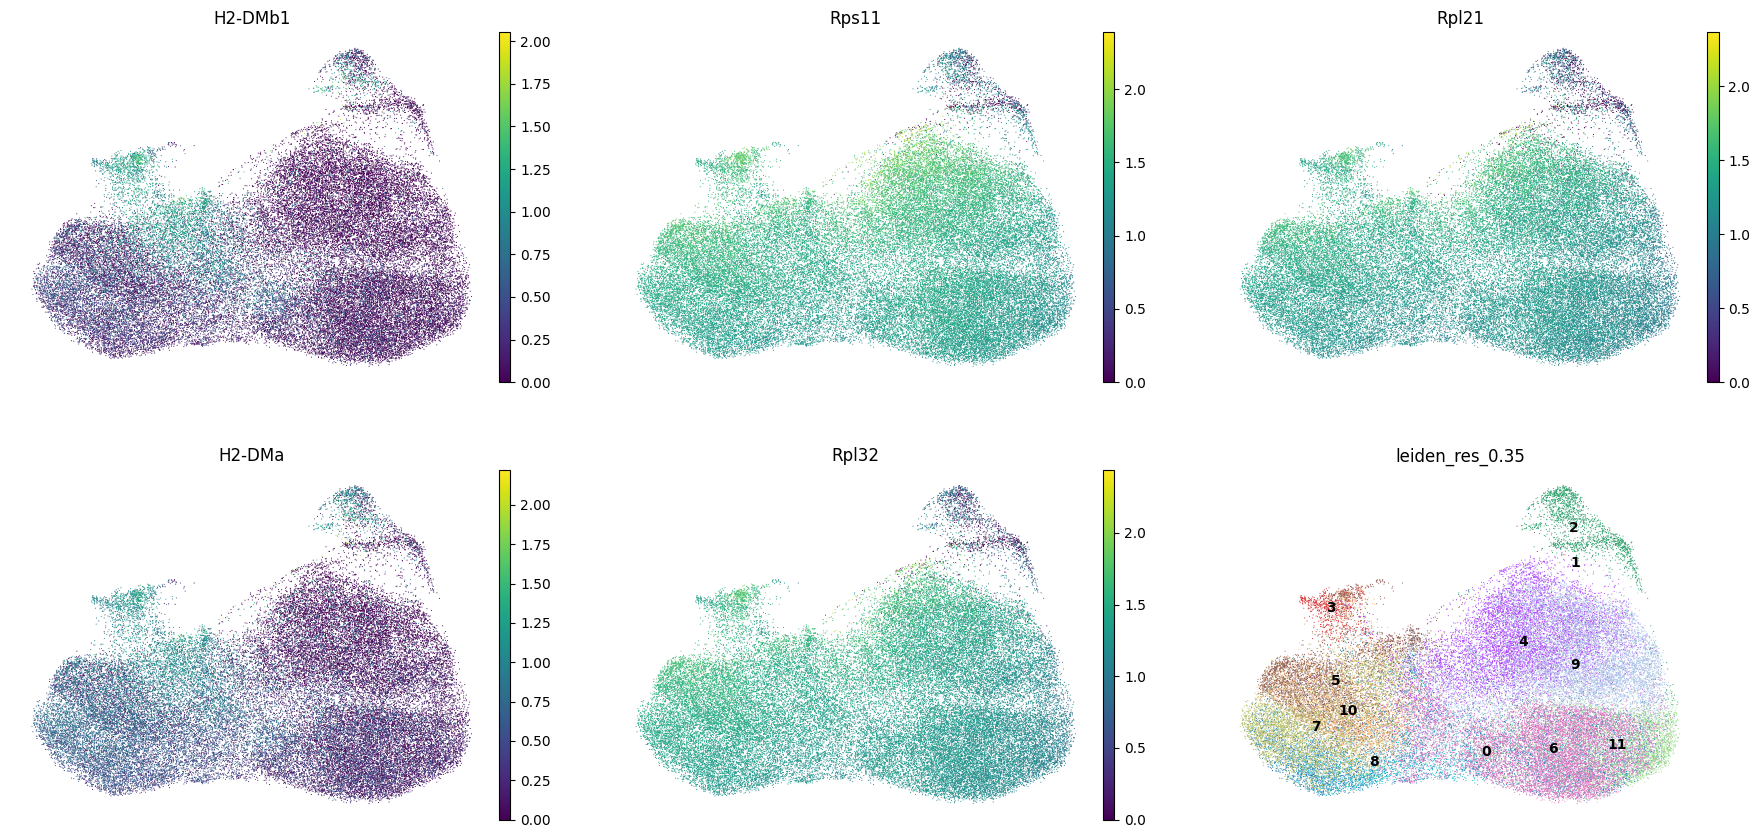

In [12]:
sc.pl.umap(
    adata,
    color=[*dc_cluster_genes, clustering],
    legend_loc="on data",
    frameon=False,
    ncols=3,
)

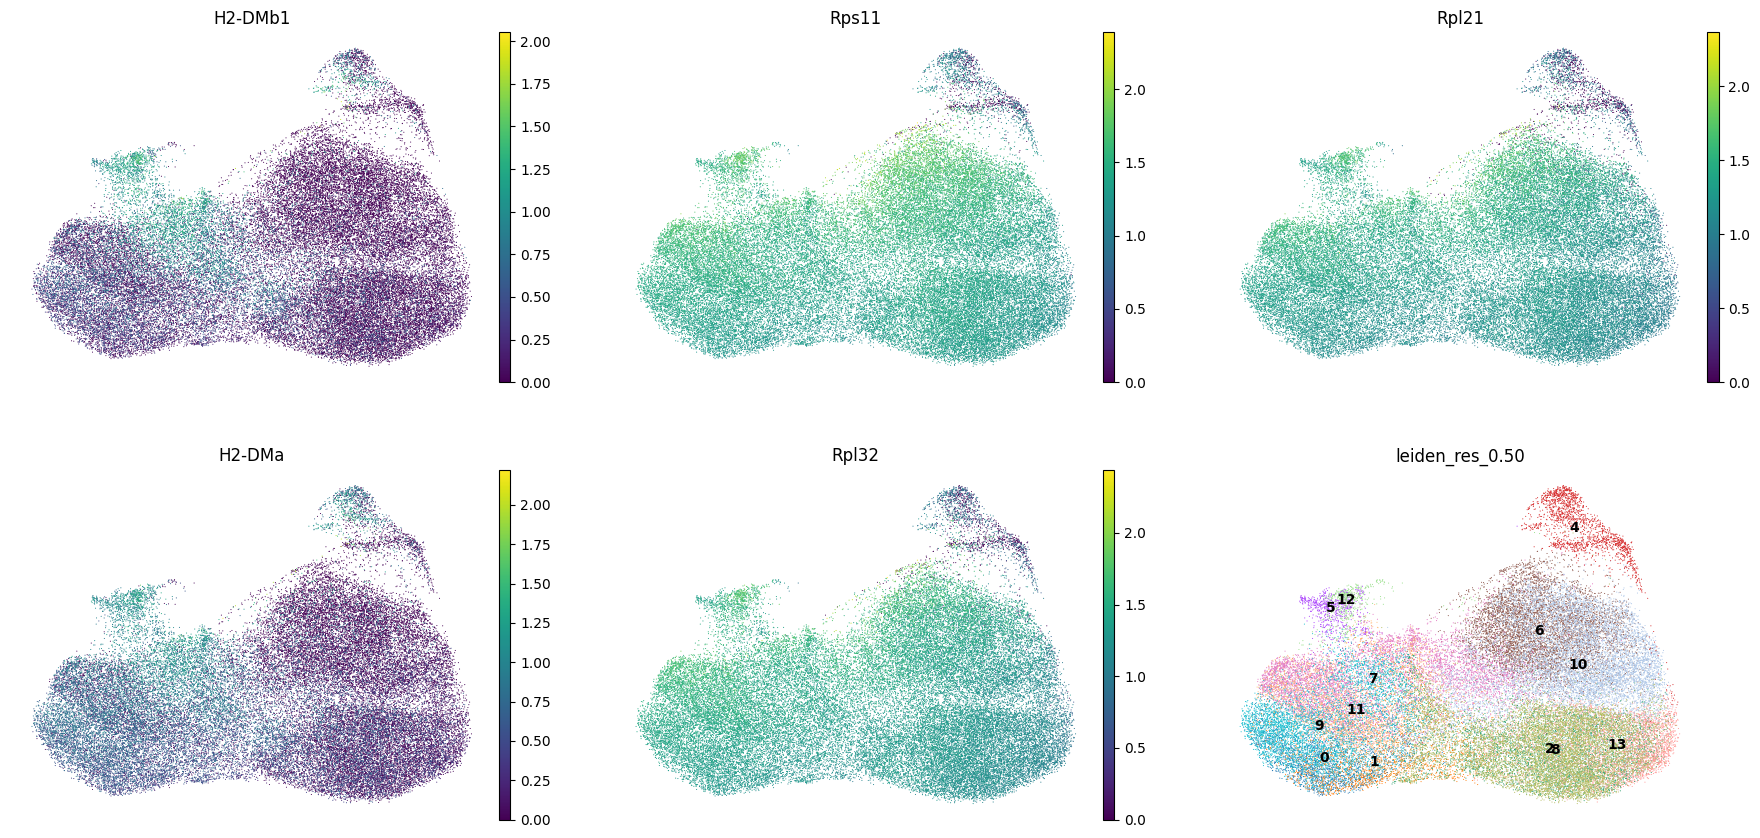

In [13]:
sc.pl.umap(
    adata,
    color=[*dc_cluster_genes, "leiden_res_0.50"],
    legend_loc="on data",
    frameon=False,
    ncols=3,
)

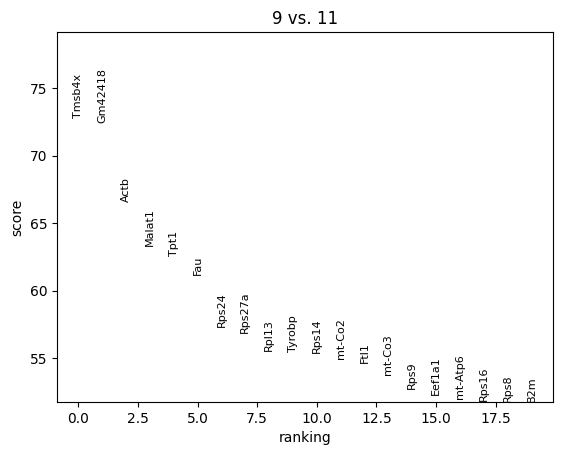

c:\Users\Hew\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\plotting\_tools\__init__.py:1314: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


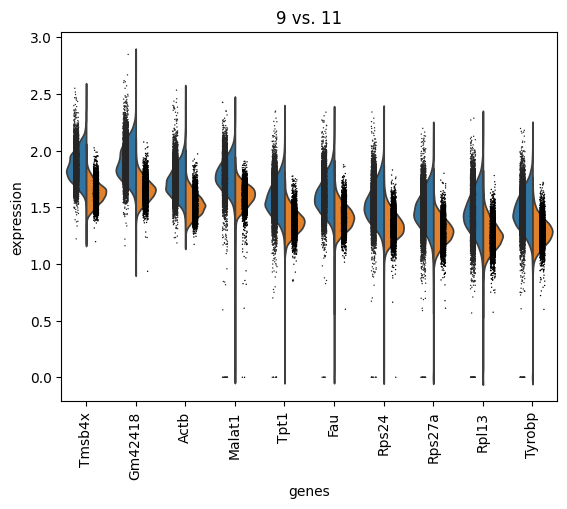

In [14]:
# COMPARE CLUSTERS PAIRWISE

pair = ("9","11")

sc.tl.rank_genes_groups(adata, clustering, groups=[pair[0]], reference=pair[1], method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=[pair[0]], n_genes=20)

sc.pl.rank_genes_groups_violin(adata, groups=[pair[0]], n_genes=10)

# plot the same genes as violins across all the datasets.

# convert numpy.recarray to list
#mynames = [x[0] for x in adata.uns['rank_genes_groups']['names'][:10]]
#sc.pl.stacked_violin(adata, mynames, groupby = clustering)

# source = "12"

In [15]:
adata.obs

n_genes_by_counts  \
AAACCCACAAAGCTCT-1-12w_KO_01_processed.h5ad               3887   
AAACCCACATTCATCT-1-12w_KO_01_processed.h5ad               2897   
AAACCCAGTGATGTAA-1-12w_KO_01_processed.h5ad               3639   
AAACCCATCGAGTCTA-1-12w_KO_01_processed.h5ad               1923   
AAACCCATCGCAACAT-1-12w_KO_01_processed.h5ad               3757   
...                                                        ...   
TTTGTTGGTCTGATAC-1-ss_WT_processed.h5ad                   2899   
TTTGTTGTCGAGGCAA-1-ss_WT_processed.h5ad                   2653   
TTTGTTGTCTCCGAAA-1-ss_WT_processed.h5ad                   2574   
TTTGTTGTCTGGGCAC-1-ss_WT_processed.h5ad                   2932   
TTTGTTGTCTTTGCTA-1-ss_WT_processed.h5ad                   3656   

                                             log1p_n_genes_by_counts  \
AAACCCACAAAGCTCT-1-12w_KO_01_processed.h5ad                 8.265650   
AAACCCACATTCATCT-1-12w_KO_01_processed.h5ad                 7.971776   
AAACCCAGTGATGTAA-1-12w_KO_01_processed.h5ad                 8.199739   
AAACCCATCGAGTCTA-1-12w_KO_01_processed.h5ad                 7.562162   
AAACCCATCGCAACAT-1-12w_KO_01_processed.h5ad                 8.231642   
...                                                              ...   
TTTGTTGGTCTGATAC-1-ss_WT_processed.h5ad                     7.972466   
TTTGTTGTCGAGGCAA-1-ss_WT_processed.h5ad                     7.883823   
TTTGTTGTCTCCGAAA-1-ss_WT_processed.h5ad                     7.853605   
TTTGTTGTCTGGGCAC-1-ss_WT_processed.h5ad                     7.983781   
TTTGTTGTCTTTGCTA-1-ss_WT_processed.h5ad                     8.204398   

                                             total_counts  log1p_total_counts  \
AAACCCACAAAGCTCT-1-12w_KO_01_processed.h5ad       16861.0            9.732818   
AAACCCACATTCATCT-1-12w_KO_01_processed.h5ad        9618.0            9.171495   
AAACCCAGTGATGTAA-1-12w_KO_01_processed.h5ad       12097.0            9.400795   
AAACCCATCGAGTCTA-1-12w_KO_01_processed.h5ad        3832.0            8.251403   
AAACCCATCGCAACAT-1-12w_KO_01_processed.h5ad       15109.0            9.623112   
...                                                   ...                 ...   
TTTGTTGGTCTGATAC-1-ss_WT_processed.h5ad            7794.0            8.961238   
TTTGTTGTCGAGGCAA-1-ss_WT_processed.h5ad            6464.0            8.774158   
TTTGTTGTCTCCGAAA-1-ss_WT_processed.h5ad            6666.0            8.804925   
TTTGTTGTCTGGGCAC-1-ss_WT_processed.h5ad            7626.0            8.939450   
TTTGTTGTCTTTGCTA-1-ss_WT_processed.h5ad           12709.0            9.450145   

                                             pct_counts_in_top_50_genes  \
AAACCCACAAAGCTCT-1-12w_KO_01_processed.h5ad                   22.804104   
AAACCCACATTCATCT-1-12w_KO_01_processed.h5ad                   24.786858   
AAACCCAGTGATGTAA-1-12w_KO_01_processed.h5ad                   20.476151   
AAACCCATCGAGTCTA-1-12w_KO_01_processed.h5ad                   19.128392   
AAACCCATCGCAACAT-1-12w_KO_01_processed.h5ad                   26.209544   
...                                                                 ...   
TTTGTTGGTCTGATAC-1-ss_WT_processed.h5ad                       20.695407   
TTTGTTGTCGAGGCAA-1-ss_WT_processed.h5ad                       20.560025   
TTTGTTGTCTCCGAAA-1-ss_WT_processed.h5ad                       21.437144   
TTTGTTGTCTGGGCAC-1-ss_WT_processed.h5ad                       17.571466   
TTTGTTGTCTTTGCTA-1-ss_WT_processed.h5ad                       22.566685   

                                             pct_counts_in_top_100_genes  \
AAACCCACAAAGCTCT-1-12w_KO_01_processed.h5ad                    32.376490   
AAACCCACATTCATCT-1-12w_KO_01_processed.h5ad                    35.818257   
AAACCCAGTGATGTAA-1-12w_KO_01_processed.h5ad                    30.065305   
AAACCCATCGAGTCTA-1-12w_KO_01_processed.h5ad                    27.400835   
AAACCCATCGCAACAT-1-12w_KO_01_processed.h5ad                    37.275796   
...                                                      

C:\Users\Hew\AppData\Local\Temp\ipykernel_13000\2911025015.py:9: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs["genotype"] = adata.obs["genotype"].replace("1", "KO")
C:\Users\Hew\AppData\Local\Temp\ipykernel_13000\2911025015.py:10: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs["genotype"] = adata.obs["genotype"].replace("0", "WT")


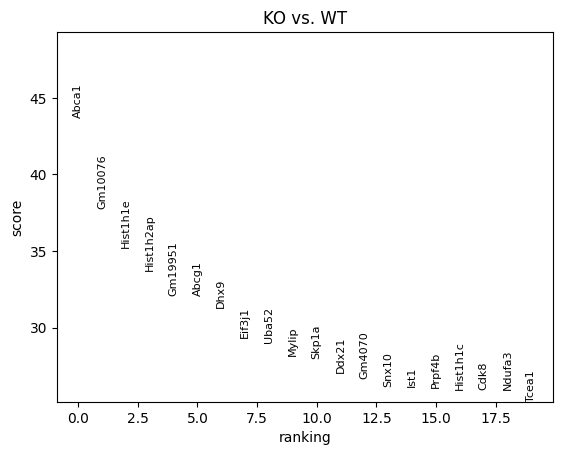

In [16]:
# COMPARE CONDITIONS by grouping by genotype

adata.obs["genotype"] = ((adata.obs["source"] == "12w_KO_01_processed.h5ad") | (adata.obs["source"] == "12w_KO_02_processed.h5ad")).astype(int)
# source == 12k01 etc. = cluster 1, WT = cluster 2 -> genotype column instead of clustering variable
adata.obs['genotype'] = adata.obs['genotype'].astype(str)

# Now convert the 'genotype' column to a categorical type with '0' and '1' as categories
adata.obs['genotype'] = adata.obs['genotype'].astype('category')
adata.obs["genotype"] = adata.obs["genotype"].replace("1", "KO")
adata.obs["genotype"] = adata.obs["genotype"].replace("0", "WT")

sc.tl.rank_genes_groups(adata, groupby="genotype", groups=["KO"], reference="WT", method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=["KO"], n_genes=20)

In [18]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np

# Assuming `adata` is your AnnData object with "genotype" stored in `adata.obs['genotype']`

# Step 1: Perform differential gene expression between "WT" and "KOs"
# You can use the `rank_genes_groups` function from Scanpy
results = sc.tl.rank_genes_groups(adata, groupby="genotype", groups=["KO"], reference="WT", method='wilcoxon')



ValueError: no field of name WT-KOs

In [27]:
results['names']

rec.array([('Abca1',), ('Gm10076',), ('Hist1h1e',), ..., ('Actb',),
           ('Tpt1',), ('Tmsb4x',)],
          dtype=[('KO', 'O')])

C:\Users\Hew\AppData\Local\Temp\ipykernel_13000\2249335349.py:10: RuntimeWarning: divide by zero encountered in log10
  neg_log_pvals = -np.log10(pvals)


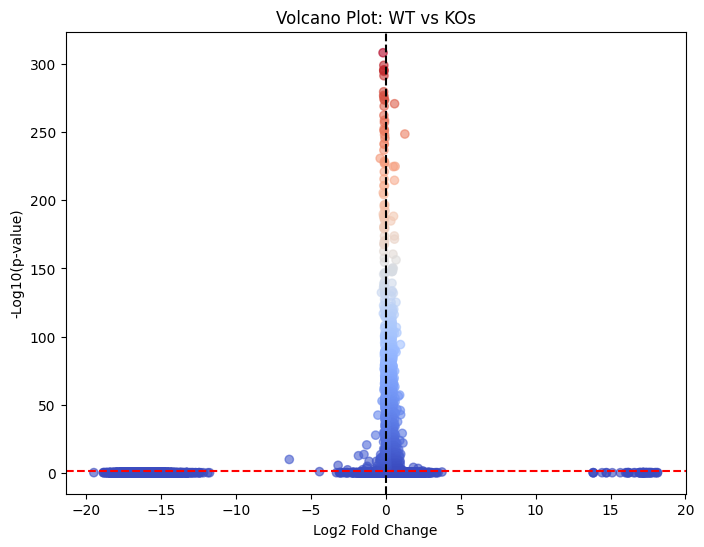

In [28]:

# Step 2: Extract the results for plotting
# Get the results: p-values and logfoldchanges
results = adata.uns['rank_genes_groups']
names = results['names']['KO']  # List of gene names
pvals = results['pvals']['KO']  # p-values
logfoldchanges = results['logfoldchanges']['KO']  # log2 fold changes

# Step 3: Create a volcano plot
# Compute -log10(p-values) for plotting
neg_log_pvals = -np.log10(pvals)

# Create the figure
plt.figure(figsize=(8, 6))

# Scatter plot: log fold change vs. -log10(p-value)
plt.scatter(logfoldchanges, neg_log_pvals, c=neg_log_pvals, cmap='coolwarm', alpha=0.6)

# Add labels and titles
plt.axhline(y=-np.log10(0.05), color='red', linestyle='--')  # Significance threshold
plt.axvline(x=0, color='black', linestyle='--')  # Fold change threshold
plt.title('Volcano Plot: WT vs KOs')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10(p-value)')

# Optional: Label top genes based on log fold change and p-value
top_genes = np.argsort(pvals)[:10]  # Select top 10 genes
for idx in top_genes:
    plt.annotate(names[idx], (logfoldchanges[idx], neg_log_pvals[idx]), fontsize=8, alpha=0.7)

plt.show()

C:\Users\Hew\AppData\Local\Temp\ipykernel_15040\893896582.py:7: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs["subgroup"] = adata.obs["subgroup"].replace("1", "left")
C:\Users\Hew\AppData\Local\Temp\ipykernel_15040\893896582.py:8: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs["subgroup"] = adata.obs["subgroup"].replace("0", "right")


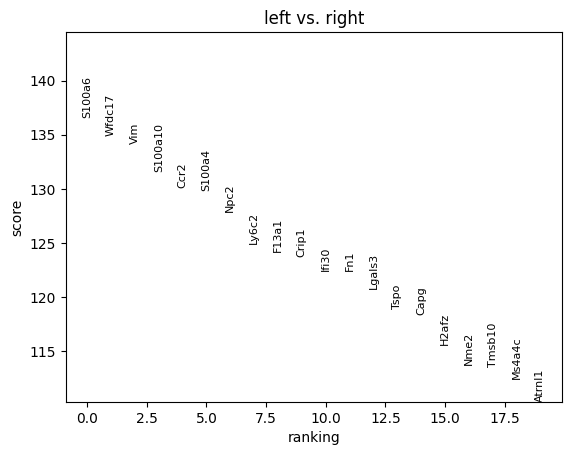

In [ ]:
# COMPARE subgroups by Ly62c expression

left = ["7", "8", "5", "10", "3"]
adata.obs["subgroup"] = (adata.obs[clustering].isin(left)).astype(int)
adata.obs['subgroup'] = adata.obs['subgroup'].astype(str)
adata.obs['subgroup'] = adata.obs['subgroup'].astype('category')
adata.obs["subgroup"] = adata.obs["subgroup"].replace("1", "left")
adata.obs["subgroup"] = adata.obs["subgroup"].replace("0", "right")

sc.tl.rank_genes_groups(adata, groupby="subgroup", groups=["left"], reference="right", method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=["left"], n_genes=20)